# Data Wrangling for Image Superresolution Project
## Purpose
The purpose of this project is to demonstrate data wrangling skills that is relevant to my capstone project.
## Recalling the project problem statement
Recall that the problem we are trying to solve is a super-resolution problem, i.e. we would like to build a neural network model which can take in an image and produce an image that is 2x the size in each dimension while recovering as much of the image quality as possible.
## The problem statement
Given our project problem statement, we can state the data wrangling problem at hand. So far, we have scraped a bunch of images from google using a scraper and stored them in a folder. In order to train our neural network, we would like to have an image dataset that is constant in its input size. Furthermore, we'd like to have images that don't have any watermarks or undesirable texts printed across the image. Since our raw dataset is small, we can go through these images one by one and delete the undesired ones.
## Data Wrangling
### Scraping and cleaning
Recall that we used the simple scraping script below to scrape a bunch of images and store them in a folder called `downloads`.

In [1]:
# First, install google_images_download
!pip install google_images_download

In [ ]:
# Then run this script
from google_images_download import google_images_download as gid

response = gid.googleimagesdownload()

keywords = '''Photography nature,
Photography city,
Photography fruits,
Photography landscape,
Photography real estate,
Photography plants,
Photography winter,
Photography autumn,
Photography wildlife,
Photography sunset
Photography mountain,
Photography sports car,
Photography objects
'''

keywords = "".join(keywords.splitlines())
arguments = {'keywords':keywords,
        'limit':100,
        'size':'>2MP',
        'print_urls':True}
paths = response.download(arguments)
print(paths)

This will simply try to download at most 100 images with given keywords ("Photography nature", "Photography city" and so on) and store them locally in folder called `downloads`.

We now have a `downloads` folder full of images. However, some of the images have undesirable effects. For instance, notice some of the datapoints below.

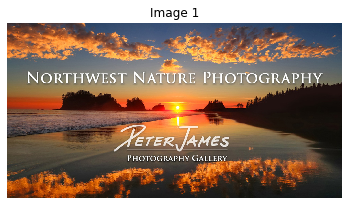

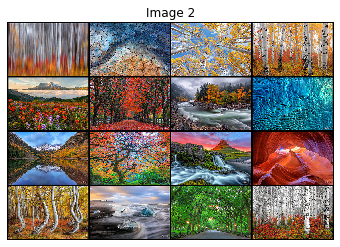

In [14]:
import matplotlib.pyplot as plt

imagepath_1 = r'downloads\Photography nature\27.ec6602_fe4ace48cd674b129ac0db6510f199a9~mv2.jpg'
imagepath_2 = r'downloads\Photography nature\10.Slide1NEW1800.jpg'

image1 = plt.imread(imagepath_1)
image2 = plt.imread(imagepath_2)
plt.axis('off')
plt.imshow(image1)
plt.title("Image 1")
plt.show()
plt.axis('off')
plt.imshow(image2)
plt.title("Image 2")
plt.show()

Image 1 above has a watermark, which isn't as clean as just a standard image. Image 2 is a compilation of a lot of other images, which may or may not introduce issues further down the line. In order to fix this issue, we can simply apply human labor and remove the undesired images from our folder. Although this reduces the size of our dataset, we can always go back and scrape more images if necessary.

### Find the smallest dimension

We would like to scale and crop every image to a fixed input size. In order to do this, we need to know the safest dimension to use when we crop our images. To find the smallest width on any image and the smallest height in any image, we run the script below.

In [37]:
import cv2
import os

root_dir = os.getcwd()
downloads_dir = root_dir + '\\downloads'

smallest_dim = [10000, 10000]

for subdir, dirs, files in os.walk(downloads_dir):
    for file in files:
        try:
            image = cv2.imread(os.path.join(subdir, file))
            width = int(image.shape[1])
            height = int(image.shape[0])
            if smallest_dim[0] > height:
                smallest_dim[0] = height
                print('new smallest dim:', tuple(smallest_dim))
            if smallest_dim[1] > width:
                smallest_dim[1] = width
                print('new smallest dim:', tuple(smallest_dim))
        except AttributeError:
            #"Weird attribute error that's not worth worrying about"
            pass

print("smallest dim:", tuple(smallest_dim))

new smallest dim: (2048, 10000)
new smallest dim: (2048, 1365)
new smallest dim: (1253, 1365)
new smallest dim: (1200, 1365)
new smallest dim: (1000, 1365)
new smallest dim: (1000, 1184)
new smallest dim: (1000, 1125)
new smallest dim: (1000, 1120)
new smallest dim: (965, 1120)
new smallest dim: (965, 1080)
smallest dim: (965, 1080)


We now know that the largest dimension we can use to crop and still be ok is 965x1080. As long as we choose a width and height that are smaller than this dimension, we'll be ok to crop the image.

### Cropping all images
I decided to crop all images down to 600x600. The decision on this number was arbitrary and justified by the fact that it's smaller than the safe dimension we found above.

Below is the script I used to scale down images and crop them to transform all images to a dimension of 600x600. It also standardizes the image name (i.e. instead of random image names, we have `1.png` and `2.png` and so on).

In [ ]:
import cv2
import os

root_dir = os.getcwd()
downloads_dir = root_dir + '\\downloads'

# if path doesn't exist, create it
if not os.path.exists(root_dir + '\\standardized'):
    os.makedirs(root_dir + '\\standardized')
standardized_dir = root_dir + '\\standardized'

count = 1
for subdir, dirs, files in os.walk(downloads_dir):
    for file in files:
        try:
            image = cv2.imread(os.path.join(subdir, file))
            print("current image shape:", image.shape)
            width = int(image.shape[1])
            height = int(image.shape[0])
            scale_constant = max((610.0 / width), (610.0 / height))
            dim = (int(width * scale_constant), int(height * scale_constant))
            resized_img = cv2.resize(image, dim)
            resized_img = resized_img[0:600, 0:600]
            print("new image shape: ", resized_img.shape)
            # cv2.imwrite(original_dir + '\\' + str(count) + '.png', image)
            cv2.imwrite(standardized_dir + '\\' + str(count) + '.png', resized_img)
            count += 1
        except AttributeError:
            print("attribute error. skipping...")
            pass # if you run into weird Nonetype errors, just ignore them

### Creating the final dataset
Now that every image has size 600x600, we can create our desired dataset. We can structure the dataset such that one folder contains all of the original 600x600 images and another folder contains those same images scaled down to 300x300. Hence, we created two folders, `downscaled` and `original`, the first to be used as input data and the second to be used to compute the loss for our model.

The script below performs the desired operations.

In [ ]:
"""
This script resizes the downloaded images to
half the size in each dimension.
"""

import cv2
import os

root_dir = os.getcwd()
downloads_dir = root_dir + '\\standardized'

if not os.path.exists(root_dir + '\\dataset\\original'):
    os.makedirs(root_dir + '\\dataset\\original')
original_dir = root_dir + '\\dataset\\original'
    
if not os.path.exists(root_dir + '\\dataset\\downscaled'):
    os.makedirs(root_dir + '\\dataset\\downscaled')
downscaled_dir = root_dir + '\\dataset\\downscaled'

count = 1
for subdir, dirs, files in os.walk(downloads_dir):
    for file in files:
        print('Processing', os.path.join(subdir, file))
        try:
            image = cv2.imread(os.path.join(subdir, file))
            width = int(image.shape[1] * 0.5)
            height = int(image.shape[0] * 0.5)
            resized_img = cv2.resize(image, (width, height))
            cv2.imwrite(original_dir + '\\' + str(count) + '.png', image)
            cv2.imwrite(downscaled_dir + '\\' + str(count) + '.png', resized_img)
            count += 1
        except AttributeError:
            pass # if you run into weird Nonetype errors, just ignore them

## Final Dataset
The script below shows the number of images in our final dataset and some example datapoints from that dataset. As we can see, we have 1087 images of size 300x300 and 1087 of corresponding images of size 600x600, both sets are contained in their own folder.

This dataset is now ready to be used for training our neural network.

Dataset info
------------
Number of images in downscaled folder: 1087
Number of images in original folder: 1087

Example Datapoints
------------------


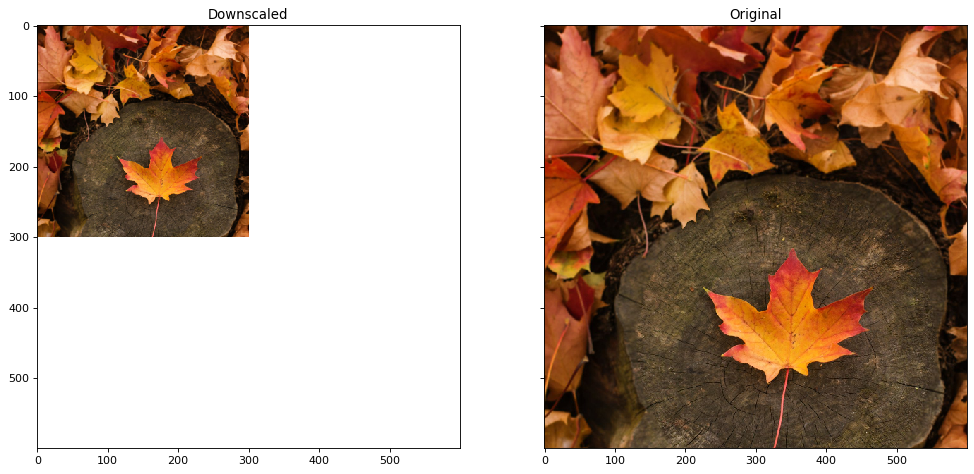

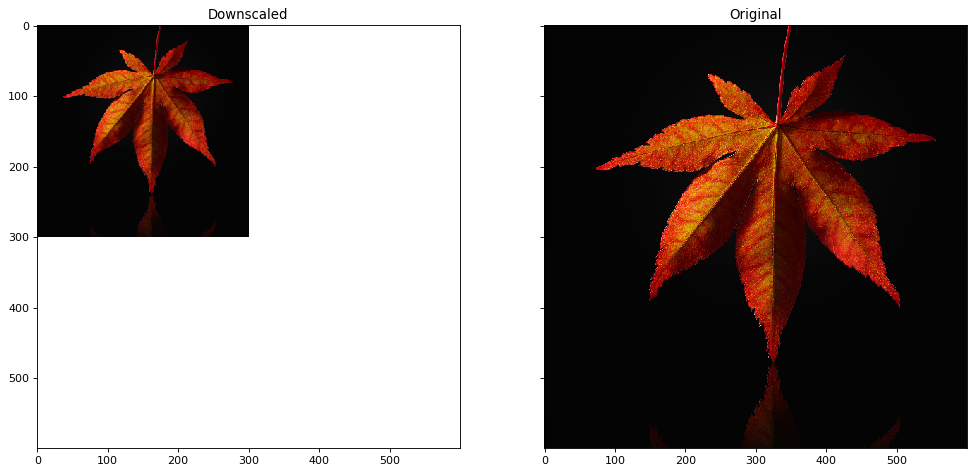

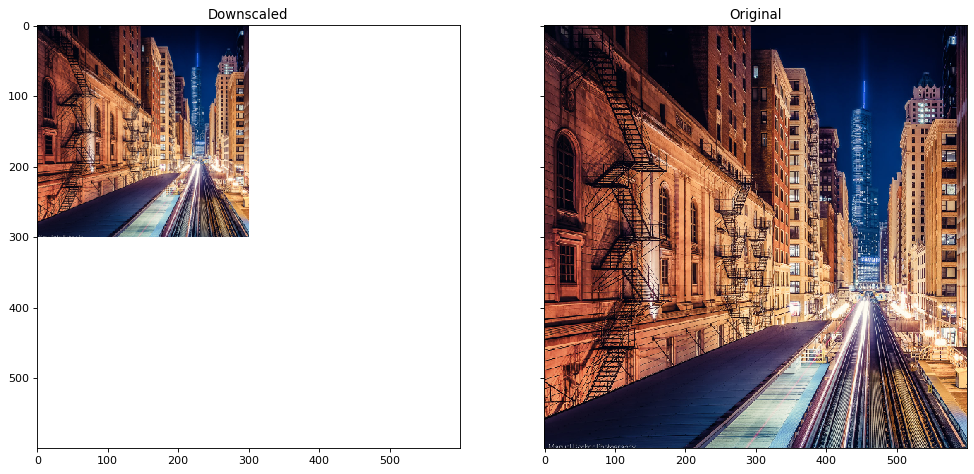

In [36]:
import matplotlib.pyplot as plt
import os

path, dirs, files = next(os.walk(r"dataset\downscaled"))
num_of_downscaled_images = len(files)
path, dirs, files = next(os.walk(r"dataset\original"))
num_of_original_images = len(files)

print("Dataset info")
print("------------")
print("Number of images in downscaled folder:", num_of_downscaled_images)
print("Number of images in original folder:", num_of_original_images)
print("")
print("Example Datapoints")
print("------------------")

downscaled_dir = "dataset\\downscaled\\"
original_dir = "dataset\\original\\"

for i in range(1, 4):
    downscaled_imagepath = downscaled_dir + str(i) + '.png'
    original_imagepath = original_dir + str(i) + '.png'

    image1 = plt.imread(downscaled_imagepath)
    image2 = plt.imread(original_imagepath)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), dpi=80, sharex=True, sharey=True)
    ax[0].imshow(image1, cmap='gray')
    ax[0].set_title("Downscaled")
    ax[1].imshow(image2, cmap='gray')
    ax[1].set_title("Original")
    plt.show()